# YOLOv8 행사 배치도 객체 인식 - 전체 파이프라인 실습

이 노트북에서는 YOLOv8을 사용하여 행사 배치도 이미지에서 객체를 인식하는 전체 파이프라인을 학습합니다.

## 학습 목표
1. YOLOv8 환경을 설정하고 필수 패키지를 설치할 수 있습니다
2. 행사 배치도 이미지를 수집하고 라벨링할 수 있습니다
3. 커스텀 YOLOv8 모델을 학습시킬 수 있습니다
4. 학습된 모델로 새로운 배치도를 분석할 수 있습니다
5. 객체 인식 결과를 안전 분석에 활용할 수 있습니다

## 대상 클래스 (8개)

| ID | 영문명 | 한글명 | 설명 |
|----|--------|--------|------|
| 0 | booth | 부스 | 전시/판매 부스 |
| 1 | stage | 무대 | 공연/행사 무대 |
| 2 | exit | 출구 | 비상구/일반 출구 |
| 3 | entrance | 입구 | 메인/보조 입구 |
| 4 | restroom | 화장실 | 화장실 시설 |
| 5 | food_area | 음식구역 | 푸드코트/음식점 |
| 6 | seating | 좌석구역 | 객석/휴게공간 |
| 7 | boundary | 경계선 | 행사장 전체 경계선 |

> **통로**: boundary 내부에서 위 클래스(0~6)를 제외한 영역이 자동으로 통로로 계산됩니다.

## 전체 파이프라인
```
데이터 수집 → 라벨링 → 데이터셋 구성 → 모델 학습 → 검증 → 추론 → 통로 자동 계산 → 안전 분석
```

## 1. 환경 설정 및 패키지 설치

YOLOv8 실습에 필요한 모든 패키지를 설치합니다. GPU가 있으면 CUDA 지원 PyTorch를 설치하여 학습 속도를 크게 향상시킬 수 있습니다.

In [1]:
# 필수 패키지 설치
import subprocess
import sys

def install_packages():
    """YOLOv8 실습에 필요한 패키지 설치"""
    packages = [
        'numpy',            # 수치 연산
        'torch',            # PyTorch
        'torchvision',      # 이미지 변환
        'ultralytics',      # YOLOv8
        'opencv-python',    # 이미지 처리
        'matplotlib',       # 시각화
        'pandas',           # 데이터 분석
        'pillow',           # 이미지 처리
        'pyyaml',           # YAML 파일 처리
        'tqdm',             # 진행률 표시
        'seaborn',          # 통계 시각화
        'labelImg',         # 라벨링 도구
    ]
    
    for package in packages:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    
    print("\n✅ 모든 패키지 설치 완료!")

# 패키지 설치 (처음 실행 시 주석 해제)
install_packages()

Installing numpy...
Installing torch...
Installing torchvision...
Installing ultralytics...
Installing opencv-python...
Installing matplotlib...
Installing pandas...
Installing pillow...
Installing pyyaml...
Installing tqdm...
Installing seaborn...
Installing labelImg...

✅ 모든 패키지 설치 완료!


In [2]:
# GPU PyTorch 설치 안내 (선택사항)
# NVIDIA GPU가 있는 경우 아래 명령어로 CUDA 지원 PyTorch 설치

# CUDA 11.8:
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

# CUDA 12.1:
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Apple Silicon (M1/M2/M3):
# pip install torch torchvision  # MPS 자동 지원

print("GPU PyTorch 설치가 필요한 경우 위 주석의 명령어를 터미널에서 실행하세요.")

GPU PyTorch 설치가 필요한 경우 위 주석의 명령어를 터미널에서 실행하세요.


## 2. 라이브러리 임포트 및 환경 확인

In [25]:
# 필수 라이브러리 임포트
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import json
import shutil
import random
from pathlib import Path
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
import torch

# 시각화 설정 (한글 폰트)
# plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ 라이브러리 임포트 완료")

✅ 라이브러리 임포트 완료


In [5]:
# 실행 환경 정보 확인
print("=" * 50)
print("실행 환경 정보")
print("=" * 50)
print(f"Python 버전: {sys.version}")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA 버전: {torch.version.cuda}")
    print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print("Apple MPS 가속 사용 가능")

# 디바이스 설정
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"\n🖥️ 사용 디바이스: {device}")

실행 환경 정보
Python 버전: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
PyTorch 버전: 2.9.1+cpu
CUDA 사용 가능: False

🖥️ 사용 디바이스: cpu


## 3. 프로젝트 디렉토리 구조 생성

YOLOv8 학습에 필요한 표준 디렉토리 구조를 생성합니다.

```
project_root/
├── data/
│   ├── images/
│   │   ├── train/     # 학습용 이미지 (80%)
│   │   ├── val/       # 검증용 이미지 (10%)
│   │   └── test/      # 테스트용 이미지 (10%)
│   └── labels/
│       ├── train/     # 학습용 라벨
│       ├── val/       # 검증용 라벨
│       └── test/      # 테스트용 라벨
├── models/            # 학습된 모델 저장
├── results/           # 추론 결과 저장
├── configs/           # 설정 파일
└── samples/           # 원본 이미지 업로드
```

In [7]:
# 프로젝트 경로 정의
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'data'
IMAGES_DIR = DATA_DIR / 'images'
LABELS_DIR = DATA_DIR / 'labels'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'
CONFIGS_DIR = PROJECT_ROOT / 'configs'
SAMPLES_DIR = PROJECT_ROOT / 'samples'

# 하위 경로 정의
TRAIN_IMAGES = IMAGES_DIR / 'train'
VAL_IMAGES = IMAGES_DIR / 'val'
TEST_IMAGES = IMAGES_DIR / 'test'
TRAIN_LABELS = LABELS_DIR / 'train'
VAL_LABELS = LABELS_DIR / 'val'
TEST_LABELS = LABELS_DIR / 'test'

print(f"프로젝트 루트: {PROJECT_ROOT}")

프로젝트 루트: C:\Users\user\Documents\lab


In [8]:
# 디렉토리 생성
directories = [
    TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES,
    TRAIN_LABELS, VAL_LABELS, TEST_LABELS,
    MODELS_DIR, RESULTS_DIR, CONFIGS_DIR, SAMPLES_DIR
]

for dir_path in directories:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"✓ {dir_path.relative_to(PROJECT_ROOT)}")

print("\n✅ 모든 디렉토리 생성 완료!")

✓ data\images\train
✓ data\images\val
✓ data\images\test
✓ data\labels\train
✓ data\labels\val
✓ data\labels\test
✓ models
✓ results
✓ configs
✓ samples

✅ 모든 디렉토리 생성 완료!


## 4. 클래스 정의 및 데이터셋 설정

행사 배치도 분석을 위한 8개 클래스를 정의하고, YOLOv8 학습에 필요한 YAML 설정 파일을 생성합니다.

In [9]:
# 클래스 정의
CLASS_NAMES = [
    'booth',       # 0: 부스
    'stage',       # 1: 무대
    'exit',        # 2: 출구
    'entrance',    # 3: 입구
    'restroom',    # 4: 화장실
    'food_area',   # 5: 음식구역
    'seating',     # 6: 좌석구역
    'boundary',    # 7: 경계선
]

# 한글명 매핑
CLASS_NAMES_KR = {
    'booth': '부스',
    'stage': '무대',
    'exit': '출구',
    'entrance': '입구',
    'restroom': '화장실',
    'food_area': '음식구역',
    'seating': '좌석구역',
    'boundary': '경계선',
}

# 시각화용 색상 (BGR)
CLASS_COLORS = {
    'booth': (0, 165, 255),      # 주황
    'stage': (0, 0, 255),        # 빨강
    'exit': (0, 255, 0),         # 초록
    'entrance': (255, 255, 0),   # 청록
    'restroom': (255, 0, 255),   # 마젠타
    'food_area': (19, 69, 139),  # 갈색
    'seating': (128, 128, 128),  # 회색
    'boundary': (0, 255, 255),   # 노랑
}

# 통로 시각화 색상 (자동 계산용)
PATHWAY_COLOR = (255, 0, 0)  # 파란색 (BGR)

print(f"총 {len(CLASS_NAMES)}개 클래스 정의됨")
for idx, name in enumerate(CLASS_NAMES):
    print(f"  {idx}: {name} ({CLASS_NAMES_KR[name]})")
print(f"\n※ 통로는 boundary 내부에서 자동 계산됩니다.")

총 8개 클래스 정의됨
  0: booth (부스)
  1: stage (무대)
  2: exit (출구)
  3: entrance (입구)
  4: restroom (화장실)
  5: food_area (음식구역)
  6: seating (좌석구역)
  7: boundary (경계선)

※ 통로는 boundary 내부에서 자동 계산됩니다.


In [16]:
# YOLOv8 데이터셋 설정 파일 (YAML) 생성
dataset_config = {
    'path': str(DATA_DIR.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': len(CLASS_NAMES),
    'names': CLASS_NAMES,
}

yaml_path = CONFIGS_DIR / 'event_layout.yaml'
with open(yaml_path, 'w', encoding='utf-8') as f:
    yaml.dump(dataset_config, f, default_flow_style=False, allow_unicode=True)

print(f"✅ 데이터셋 설정 파일 생성: {yaml_path}")
print("\n파일 내용:")
print("-" * 40)
with open(yaml_path, 'r') as f:
    print(f.read())

✅ 데이터셋 설정 파일 생성: C:\Users\user\Documents\lab\configs\event_layout.yaml

파일 내용:
----------------------------------------
names:
- booth
- stage
- exit
- entrance
- restroom
- food_area
- seating
- boundary
nc: 8
path: C:\Users\user\Documents\lab\data
test: images/test
train: images/train
val: images/val



## 5. 데이터 준비 및 이미지 업로드

### 이미지 수집 지침
1. **이미지 소스**: 실제 행사 배치도, CAD 도면, 디지털 배치도
2. **요구사항**: JPG/PNG, 최소 640x640, 10MB 이하
3. **권장 수량**: 클래스당 최소 50장 이상 (총 400장+)
4. **다양성**: 다양한 행사 유형 및 스타일 포함

### 이미지 업로드 방법
1. `samples/` 폴더에 원본 이미지를 복사합니다
2. 아래 코드를 실행하여 train/val/test로 자동 분할합니다

In [17]:
# 이미지 현황 확인 함수
def check_images(directory: Path) -> dict:
    """디렉토리 내 이미지 파일 확인"""
    supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    images = [f for f in directory.iterdir() if f.is_file() and f.suffix.lower() in supported_formats]
    return {
        'count': len(images),
        'files': images,
        'directory': directory
    }

# 현재 데이터셋 상태 확인
print("📊 현재 데이터셋 상태")
print("=" * 50)

for split_name, split_dir in [('samples', SAMPLES_DIR), ('train', TRAIN_IMAGES), ('val', VAL_IMAGES), ('test', TEST_IMAGES)]:
    info = check_images(split_dir)
    status = "✓" if info['count'] > 0 else "✗"
    print(f"{status} {split_name:8}: {info['count']:4}장")

📊 현재 데이터셋 상태
✓ samples :   10장
✓ train   :   10장
✓ val     :    2장
✓ test    :    2장


In [18]:
# 데이터셋 자동 분할 함수
def split_dataset(source_dir: Path, train_ratio=0.8, val_ratio=0.1, seed=42):
    """
    samples 폴더의 이미지를 train/val/test로 분할
    
    Args:
        source_dir: 원본 이미지가 있는 디렉토리
        train_ratio: 학습 데이터 비율 (기본 80%)
        val_ratio: 검증 데이터 비율 (기본 10%)
        seed: 랜덤 시드
    """
    supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    all_images = [f for f in source_dir.iterdir() if f.is_file() and f.suffix.lower() in supported_formats]
    
    if len(all_images) == 0:
        print(f"⚠️ 이미지가 없습니다: {source_dir}")
        print(f"   samples 폴더에 이미지를 먼저 복사하세요.")
        return
    
    random.seed(seed)
    random.shuffle(all_images)
    
    n_total = len(all_images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    train_imgs = all_images[:n_train]
    val_imgs = all_images[n_train:n_train + n_val]
    test_imgs = all_images[n_train + n_val:]
    
    # 파일 복사
    for img in train_imgs:
        shutil.copy(img, TRAIN_IMAGES / img.name)
    for img in val_imgs:
        shutil.copy(img, VAL_IMAGES / img.name)
    for img in test_imgs:
        shutil.copy(img, TEST_IMAGES / img.name)
    
    print(f"✅ 데이터셋 분할 완료!")
    print(f"   Train: {len(train_imgs)}장")
    print(f"   Val:   {len(val_imgs)}장")
    print(f"   Test:  {len(test_imgs)}장")

# 데이터셋 분할 실행 (samples 폴더에 이미지가 있을 때)
split_dataset(SAMPLES_DIR)

✅ 데이터셋 분할 완료!
   Train: 8장
   Val:   1장
   Test:  1장


## 6. 라벨링 가이드

### YOLO 라벨 형식
각 이미지에 대응하는 `.txt` 파일을 생성합니다.

```
<class_id> <x_center> <y_center> <width> <height>
```

- **class_id**: 클래스 번호 (0~7)
- **x_center, y_center**: 바운딩 박스 중심 좌표 (0~1 정규화)
- **width, height**: 바운딩 박스 크기 (0~1 정규화)

### 라벨링 도구
- **LabelImg**: 오픈소스, 로컬 설치 (`pip install labelImg`)
- **Roboflow**: 클라우드 기반, 자동 분할 (https://roboflow.com)
- **CVAT**: 협업 가능, 고급 기능 (https://www.cvat.ai)

In [11]:
# classes.txt 파일 생성 (LabelImg용)
classes_file = CONFIGS_DIR / 'classes.txt'
with open(classes_file, 'w', encoding='utf-8') as f:
    for name in CLASS_NAMES:
        f.write(f"{name}\n")

print(f"✅ 클래스 파일 생성: {classes_file}")
print("\n파일 내용:")
print("-" * 20)
with open(classes_file, 'r') as f:
    print(f.read())

✅ 클래스 파일 생성: C:\Users\user\Documents\lab\configs\classes.txt

파일 내용:
--------------------
booth
stage
exit
entrance
restroom
food_area
seating
boundary



In [14]:
# LabelImg 실행 함수
def run_labelimg(image_dir: Path = None, save_dir: Path = None, classes_file: Path = None):
    """
    LabelImg 라벨링 도구 실행
    
    Args:
        image_dir: 라벨링할 이미지 디렉토리
        save_dir: 라벨 저장 디렉토리
        classes_file: 클래스 정의 파일 경로
    """
    import subprocess
    
    # LabelImg CLI: labelImg [image_dir] [class_file] [save_dir]
    cmd = ['labelImg']
    
    if image_dir:
        cmd.append(str(image_dir))
    if classes_file:  # 두 번째 인자: class_file
        cmd.append(str(classes_file))
    if save_dir:      # 세 번째 인자: save_dir
        cmd.append(str(save_dir))
    
    print("🏷️ LabelImg 실행 중...")
    print(f"   이미지 폴더: {image_dir}")
    print(f"   클래스 파일: {classes_file}")
    print(f"   라벨 저장: {save_dir}")
    print("\n💡 팁: YOLO 포맷으로 저장하려면 View > Change Save Format > YOLO 선택")
    
    try:
        subprocess.Popen(cmd)
    except FileNotFoundError:
        print("\n⚠️ LabelImg가 설치되지 않았습니다.")
        print("   설치: pip install labelImg")

# LabelImg 실행 (학습 이미지 라벨링)
run_labelimg(TRAIN_IMAGES, TRAIN_LABELS, classes_file)

🏷️ LabelImg 실행 중...
   이미지 폴더: C:\Users\user\Documents\lab\data\images\train
   클래스 파일: C:\Users\user\Documents\lab\configs\classes.txt
   라벨 저장: C:\Users\user\Documents\lab\data\labels\train

💡 팁: YOLO 포맷으로 저장하려면 View > Change Save Format > YOLO 선택


In [16]:
# 라벨 검증 함수
def validate_labels(labels_dir: Path, images_dir: Path):
    """라벨 파일 검증"""
    supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    
    image_files = {f.stem for f in images_dir.iterdir() if f.suffix.lower() in supported_formats}
    label_files = {f.stem for f in labels_dir.iterdir() if f.suffix == '.txt'}
    
    missing_labels = image_files - label_files
    extra_labels = label_files - image_files
    matched = image_files & label_files
    
    print(f"📊 라벨 검증 결과")
    print("=" * 50)
    print(f"✓ 매칭된 이미지-라벨: {len(matched)}개")
    print(f"✗ 라벨 없는 이미지: {len(missing_labels)}개")
    print(f"✗ 이미지 없는 라벨: {len(extra_labels)}개")
    
    if missing_labels:
        print(f"\n라벨 없는 이미지 예시: {list(missing_labels)[:5]}")
    
    return {
        'matched': len(matched),
        'missing_labels': len(missing_labels),
        'extra_labels': len(extra_labels)
    }

# 라벨 검증 실행
for split_name, (img_dir, lbl_dir) in [
    ('train', (TRAIN_IMAGES, TRAIN_LABELS)),
    ('val', (VAL_IMAGES, VAL_LABELS)),
    ('test', (TEST_IMAGES, TEST_LABELS))
]:
    print(f"\n[{split_name}]")
    validate_labels(lbl_dir, img_dir)


[train]
📊 라벨 검증 결과
✓ 매칭된 이미지-라벨: 8개
✗ 라벨 없는 이미지: 0개
✗ 이미지 없는 라벨: 0개

[val]
📊 라벨 검증 결과
✓ 매칭된 이미지-라벨: 1개
✗ 라벨 없는 이미지: 0개
✗ 이미지 없는 라벨: 0개

[test]
📊 라벨 검증 결과
✓ 매칭된 이미지-라벨: 1개
✗ 라벨 없는 이미지: 0개
✗ 이미지 없는 라벨: 0개


## 7. 데이터셋 통계

라벨링된 데이터셋의 클래스별 객체 수를 확인합니다.

📊 데이터셋 통계

[이미지 수]
  train :    8장
  val   :    1장
  test  :    1장

[클래스별 객체 수]
       booth  stage  exit  entrance  restroom  food_area  seating  boundary   합계
train    569      4    20        18         8          2       47        11  679
val       63      1     1         1         0          0        3         1   70
test      54      0     1         1         0          0        0         1   57


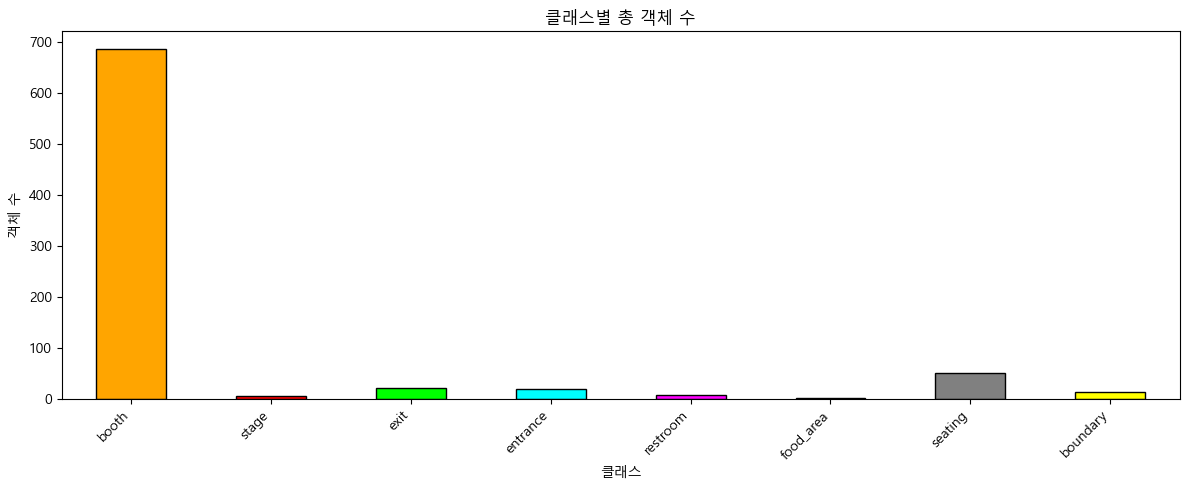

In [26]:
# 데이터셋 통계 함수
def dataset_statistics():
    """데이터셋 이미지 수 및 클래스별 객체 수 집계"""
    stats = {'train': {}, 'val': {}, 'test': {}}
    class_counts = {split: {name: 0 for name in CLASS_NAMES} for split in stats.keys()}
    
    for split, (img_dir, lbl_dir) in [
        ('train', (TRAIN_IMAGES, TRAIN_LABELS)),
        ('val', (VAL_IMAGES, VAL_LABELS)),
        ('test', (TEST_IMAGES, TEST_LABELS))
    ]:
        # 이미지 수
        supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
        images = [f for f in img_dir.iterdir() if f.is_file() and f.suffix.lower() in supported_formats]
        stats[split]['images'] = len(images)
        
        # 클래스별 객체 수
        for lbl_file in lbl_dir.glob('*.txt'):
            with open(lbl_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        if 0 <= class_id < len(CLASS_NAMES):
                            class_counts[split][CLASS_NAMES[class_id]] += 1
    
    # 결과 출력
    print("📊 데이터셋 통계")
    print("=" * 60)
    
    # 이미지 수
    print("\n[이미지 수]")
    for split, info in stats.items():
        print(f"  {split:6}: {info.get('images', 0):4}장")
    
    # 클래스별 객체 수
    print("\n[클래스별 객체 수]")
    df = pd.DataFrame(class_counts).T
    df['합계'] = df.sum(axis=1)
    print(df.to_string())
    
    # 시각화
    total_counts = pd.Series({name: sum(class_counts[split][name] for split in stats.keys()) for name in CLASS_NAMES})
    if total_counts.sum() > 0:
        plt.figure(figsize=(12, 5))
        colors = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in [CLASS_COLORS[name][::-1] for name in CLASS_NAMES]]
        total_counts.plot(kind='bar', color=colors, edgecolor='black')
        plt.xlabel('클래스')
        plt.ylabel('객체 수')
        plt.title('클래스별 총 객체 수')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    return stats, class_counts

# 통계 실행
stats, class_counts = dataset_statistics()

## 8. YOLOv8 모델 학습

### 모델 크기 선택 가이드

| 모델 | 파라미터 | mAP | 속도 | 권장 환경 |
|------|----------|-----|------|-----------|
| YOLOv8n | 3.2M | 37.3 | 빠름 | 일반 PC, 빠른 학습 |
| YOLOv8s | 11.2M | 44.9 | 중간 | 권장 (균형) |
| YOLOv8m | 25.9M | 50.2 | 느림 | 고성능 GPU |
| YOLOv8l | 43.7M | 52.9 | 매우 느림 | 서버급 GPU |

빠른 실습을 위해 YOLOv8n(nano) 모델을 사용합니다.

In [44]:
# 기본 모델 로드
# MODEL_NAME = 'yolov8n.pt'  # nano 모델 (빠른 학습용)
# MODEL_NAME = 'yolov8s.pt'  # small 모델 (권장)
MODEL_NAME = 'yolov8m.pt'  # medium 모델 (고성능)

base_model = YOLO(MODEL_NAME)
print(f"✅ 기본 모델 로드: {MODEL_NAME}")
print(f"   파라미터 수: {sum(p.numel() for p in base_model.model.parameters()):,}")

✅ 기본 모델 로드: yolov8m.pt
   파라미터 수: 25,902,640


In [45]:
# 학습 설정
TRAIN_CONFIG = {
    'data': str(CONFIGS_DIR / 'event_layout.yaml'),  # 데이터셋 설정 파일
    'epochs': 100,           # 학습 에폭 수
    'batch': 16,             # 배치 크기 (GPU 메모리에 따라 조절)
    'imgsz': 640,            # 입력 이미지 크기
    'device': device,        # 학습 디바이스
    'patience': 30,          # Early stopping patience
    'save': True,            # 체크포인트 저장
    'project': str(RESULTS_DIR),
    'name': 'event_layout_train',
    'exist_ok': True,
    'pretrained': True,      # 사전학습 가중치 사용
    'optimizer': 'auto',     # 옵티마이저
    'lr0': 0.01,             # 초기 학습률
    'lrf': 0.01,             # 최종 학습률 비율
    'augment': True,         # 데이터 증강
    'mosaic': 1.0,           # 모자이크 증강
    'fliplr': 0.5,           # 좌우 반전 확률
    'flipud': 0.0,           # 상하 반전 확률
}

print("📋 학습 설정")
print("=" * 50)
for key, value in TRAIN_CONFIG.items():
    print(f"  {key}: {value}")

📋 학습 설정
  data: C:\Users\user\Documents\lab\configs\event_layout.yaml
  epochs: 100
  batch: 16
  imgsz: 640
  device: cpu
  patience: 30
  save: True
  project: C:\Users\user\Documents\lab\results
  name: event_layout_train
  exist_ok: True
  pretrained: True
  optimizer: auto
  lr0: 0.01
  lrf: 0.01
  augment: True
  mosaic: 1.0
  fliplr: 0.5
  flipud: 0.0


In [46]:
# 모델 학습 함수
def train_model():
    """YOLOv8 모델 학습 실행"""
    # 데이터 확인
    train_images = list(TRAIN_IMAGES.glob('*.*'))
    train_labels = list(TRAIN_LABELS.glob('*.txt'))
    
    if len(train_images) == 0:
        print("⚠️ 학습 이미지가 없습니다.")
        print(f"   {TRAIN_IMAGES} 폴더에 이미지를 추가하세요.")
        return None
    
    if len(train_labels) == 0:
        print("⚠️ 학습 라벨이 없습니다.")
        print(f"   {TRAIN_LABELS} 폴더에 라벨 파일을 추가하세요.")
        return None
    
    print(f"🚀 학습 시작")
    print(f"   이미지: {len(train_images)}장")
    print(f"   라벨: {len(train_labels)}개")
    print("-" * 50)
    
    # 모델 학습
    model = YOLO(MODEL_NAME)
    results = model.train(**TRAIN_CONFIG)
    
    print("\n✅ 학습 완료!")
    print(f"   최적 모델: {RESULTS_DIR / 'event_layout_train' / 'weights' / 'best.pt'}")
    
    return results

# 학습 실행 (데이터가 준비된 후 주석 해제)
training_results = train_model()

🚀 학습 시작
   이미지: 8장
   라벨: 8개
--------------------------------------------------
Ultralytics 8.3.234  Python-3.10.11 torch-2.9.1+cpu CPU (Intel Core i5-10210U 1.60GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\user\Documents\lab\configs\event_layout.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=event_layout_train, nbs=64, nms

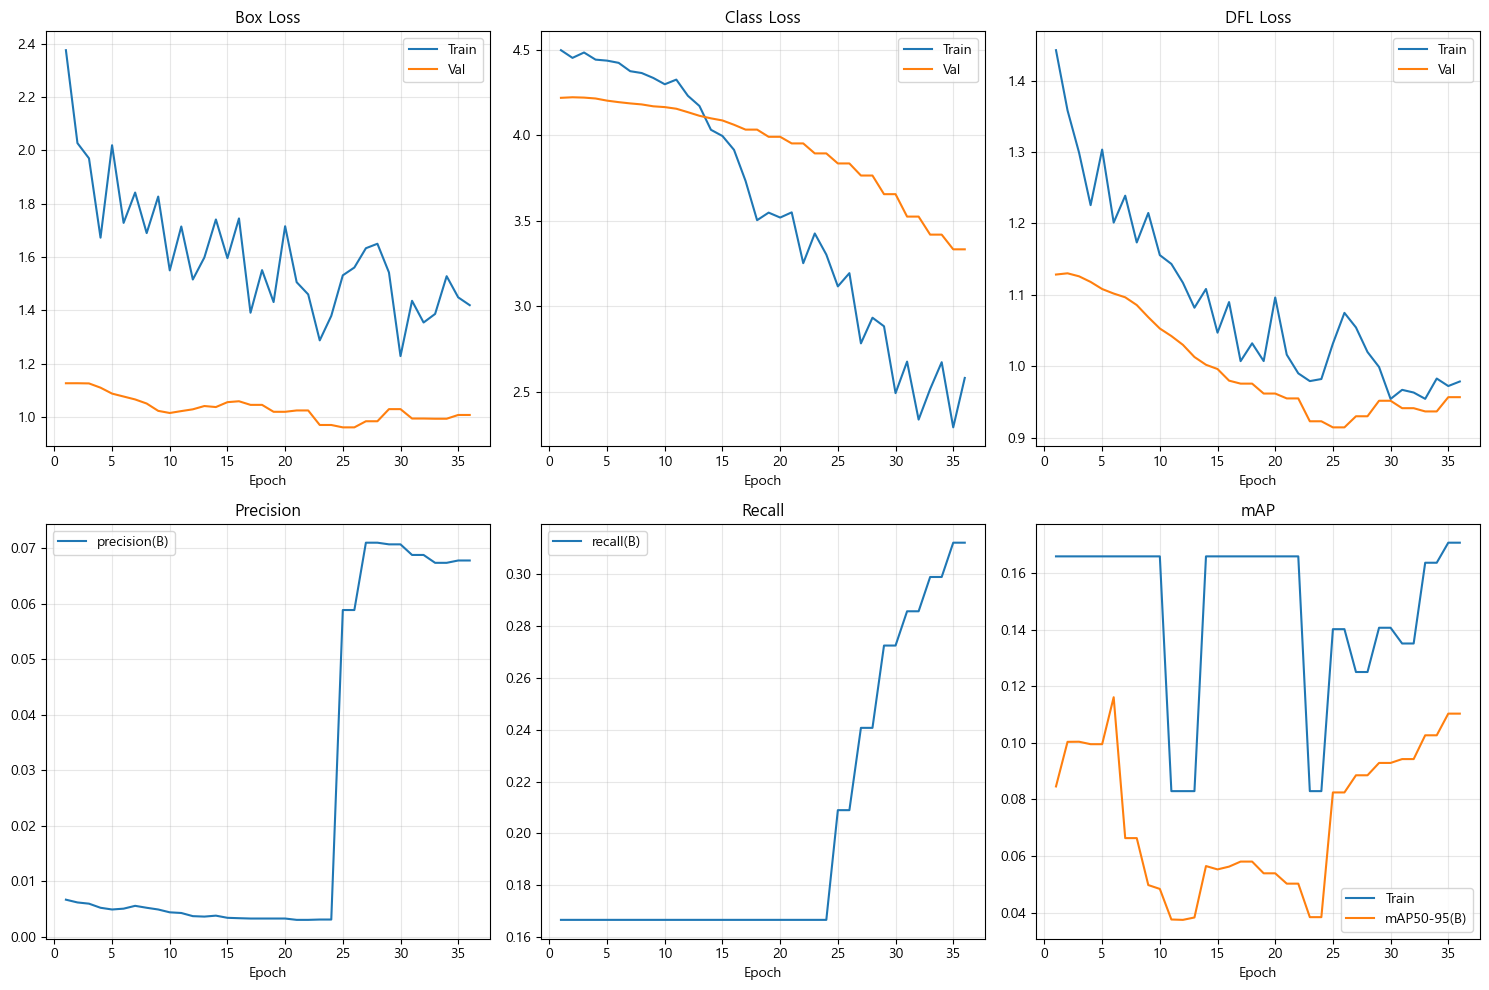


📊 최종 성능 (마지막 에폭)
   mAP50: 0.1707
   mAP50-95: 0.1103


In [30]:
# 학습 결과 시각화 함수
def show_training_results():
    """학습 결과 그래프 시각화"""
    results_csv = RESULTS_DIR / 'event_layout_train' / 'results.csv'
    
    if not results_csv.exists():
        print("⚠️ 학습 결과 파일이 없습니다.")
        print("   먼저 모델을 학습하세요.")
        return
    
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Loss 그래프
    metrics = [
        ('train/box_loss', 'val/box_loss', 'Box Loss'),
        ('train/cls_loss', 'val/cls_loss', 'Class Loss'),
        ('train/dfl_loss', 'val/dfl_loss', 'DFL Loss'),
        ('metrics/precision(B)', None, 'Precision'),
        ('metrics/recall(B)', None, 'Recall'),
        ('metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'mAP'),
    ]
    
    for idx, (col1, col2, title) in enumerate(metrics):
        ax = axes[idx // 3, idx % 3]
        if col1 in df.columns:
            ax.plot(df['epoch'], df[col1], label='Train' if col2 else col1.split('/')[-1])
        if col2 and col2 in df.columns:
            ax.plot(df['epoch'], df[col2], label='Val' if 'val' in col2 else col2.split('/')[-1])
        ax.set_xlabel('Epoch')
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 최종 성능 출력
    if 'metrics/mAP50(B)' in df.columns:
        print(f"\n📊 최종 성능 (마지막 에폭)")
        print(f"   mAP50: {df['metrics/mAP50(B)'].iloc[-1]:.4f}")
        if 'metrics/mAP50-95(B)' in df.columns:
            print(f"   mAP50-95: {df['metrics/mAP50-95(B)'].iloc[-1]:.4f}")

# 학습 결과 시각화 (학습 완료 후 실행)
show_training_results()

## 9. 모델 검증

학습된 모델의 성능을 검증 데이터셋으로 평가합니다.

In [31]:
# 학습된 모델 로드
best_model_path = RESULTS_DIR / 'event_layout_train' / 'weights' / 'best.pt'

if best_model_path.exists():
    model = YOLO(str(best_model_path))
    print(f"✅ 학습된 커스텀 모델 로드")
    print(f"   경로: {best_model_path}")
else:
    model = YOLO('yolov8n.pt')
    print("⚠️ 학습된 모델이 없어 사전학습 모델(COCO)을 사용합니다.")
    print("   커스텀 모델을 사용하려면 먼저 학습을 진행하세요.")

# 모델 정보 출력
print(f"\n📊 모델 정보")
print(f"   클래스 수: {len(model.names)}")
print(f"   클래스: {list(model.names.values())[:8]}...")

✅ 학습된 커스텀 모델 로드
   경로: C:\Users\user\Documents\lab\results\event_layout_train\weights\best.pt

📊 모델 정보
   클래스 수: 8
   클래스: ['booth', 'stage', 'exit', 'entrance', 'restroom', 'food_area', 'seating', 'boundary']...


In [32]:
# 모델 검증 함수
def evaluate_model(model, data_yaml: str):
    """검증 데이터셋으로 모델 성능 평가"""
    print("🔍 모델 검증 중...")
    
    results = model.val(
        data=data_yaml,
        split='val',
        batch=16,
        imgsz=640,
        device=device,
        verbose=False
    )
    
    print("\n📊 검증 결과")
    print("=" * 50)
    print(f"Precision: {results.results_dict['metrics/precision(B)']:.4f}")
    print(f"Recall:    {results.results_dict['metrics/recall(B)']:.4f}")
    print(f"mAP50:     {results.results_dict['metrics/mAP50(B)']:.4f}")
    print(f"mAP50-95:  {results.results_dict['metrics/mAP50-95(B)']:.4f}")
    
    return results

# 모델 검증 실행 (커스텀 모델이 있을 때)
val_results = evaluate_model(model, str(CONFIGS_DIR / 'event_layout.yaml'))

🔍 모델 검증 중...
Ultralytics 8.3.234  Python-3.10.11 torch-2.9.1+cpu CPU (Intel Core i5-10210U 1.60GHz)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1651.90.0 MB/s, size: 342.5 KB)
val: Scanning C:\Users\user\Documents\lab\data\labels\val.cache... 1 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1/1 1.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 6.1it/s 0.2s
                   all          1         70    0.00476      0.167      0.166      0.116
Speed: 2.8ms preprocess, 106.6ms inference, 0.0ms loss, 12.2ms postprocess per image
Results saved to C:\Users\user\Documents\lab\runs\detect\val2

📊 검증 결과
Precision: 0.0048
Recall:    0.1667
mAP50:     0.1658
mAP50-95:  0.1161


## 10. 새로운 배치도 추론

학습된 모델을 사용하여 새로운 행사 배치도 이미지에서 객체를 인식합니다.

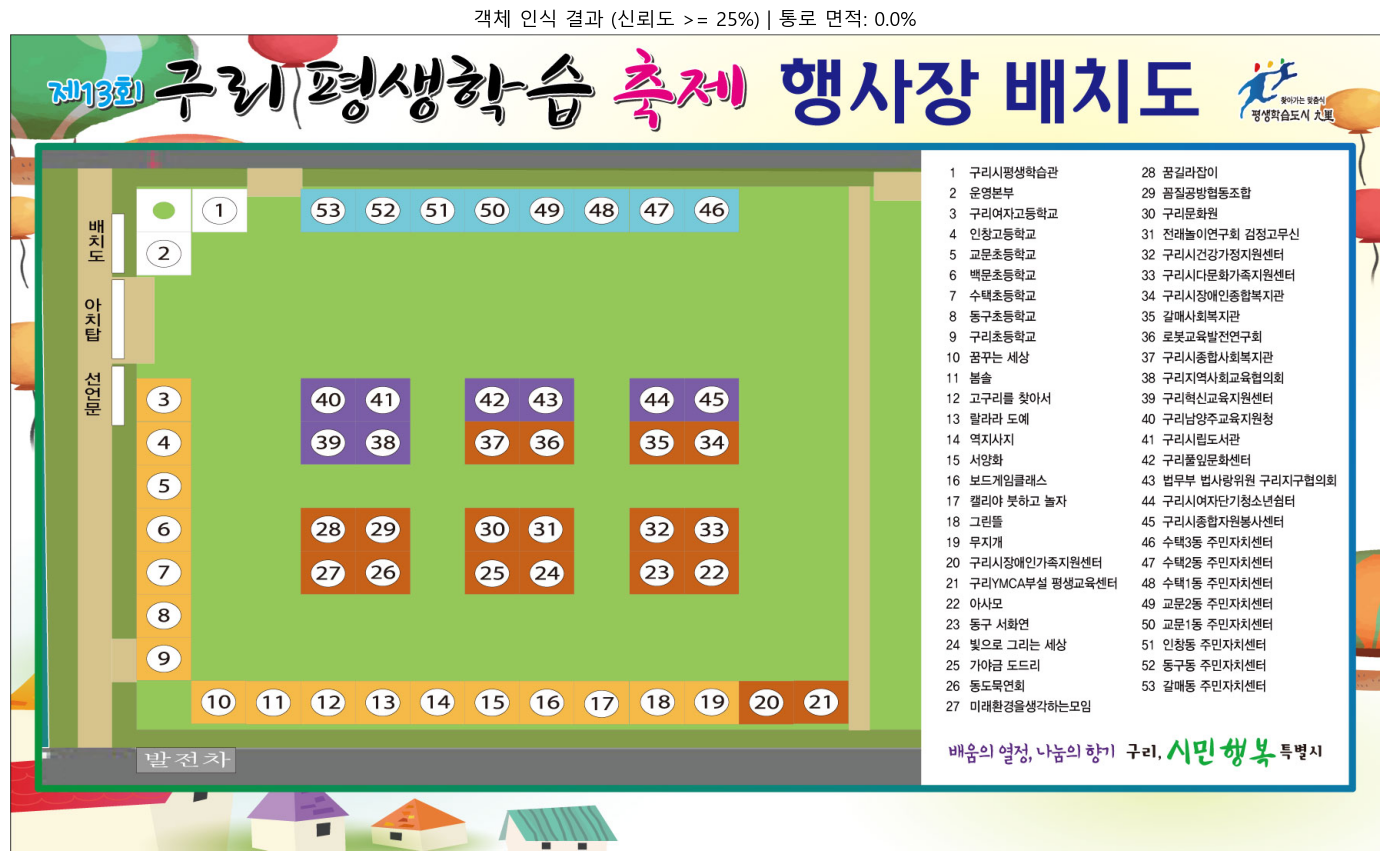


📦 인식된 객체

총 0개 객체 인식됨
📊 통로 면적: 0.0% (boundary 대비)


In [33]:
# 단일 이미지 추론 함수 (통로 자동 계산 포함)
def predict_single_image(model, image_path: str, conf_threshold: float = 0.25, show_pathway: bool = True):
    """
    단일 이미지에서 객체 인식 수행 및 통로 자동 계산
    
    Args:
        model: YOLO 모델
        image_path: 이미지 경로
        conf_threshold: 신뢰도 임계값
        show_pathway: 통로 시각화 여부
    
    Returns:
        인식된 객체 리스트
    """
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        iou=0.45,
        imgsz=640,
        device=device,
        verbose=False
    )
    
    result = results[0]
    img_with_boxes = result.plot()
    
    # 인식된 객체 정보 수집
    detected_objects = []
    for idx, box in enumerate(result.boxes):
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = model.names[class_id]
        bbox = box.xyxy[0].cpu().numpy()
        
        obj_info = {
            'id': idx + 1,
            'class': class_name,
            'class_kr': CLASS_NAMES_KR.get(class_name, class_name),
            'confidence': confidence,
            'bbox': bbox.tolist(),
        }
        detected_objects.append(obj_info)
    
    # 통로 자동 계산 및 시각화
    pathway_ratio = 0.0
    if show_pathway and detected_objects:
        img_with_pathway, pathway_ratio, pathway_mask = calculate_and_visualize_pathway(
            img_with_boxes, detected_objects
        )
        display_img = img_with_pathway
    else:
        display_img = img_with_boxes
    
    # 시각화
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    title = f'객체 인식 결과 (신뢰도 >= {conf_threshold:.0%})'
    if show_pathway:
        title += f' | 통로 면적: {pathway_ratio:.1%}'
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 인식된 객체 정보 출력
    print("\n📦 인식된 객체")
    print("=" * 60)
    
    for obj in detected_objects:
        print(f"{obj['id']}. {obj['class_kr']} ({obj['class']})")
        print(f"   신뢰도: {obj['confidence']:.2%}")
        bbox = obj['bbox']
        print(f"   좌표: ({bbox[0]:.0f}, {bbox[1]:.0f}) ~ ({bbox[2]:.0f}, {bbox[3]:.0f})")
    
    print(f"\n총 {len(detected_objects)}개 객체 인식됨")
    if show_pathway:
        print(f"📊 통로 면적: {pathway_ratio:.1%} (boundary 대비)")
    
    return detected_objects

# 테스트 이미지로 추론 실행
test_images = list(TEST_IMAGES.glob('*.*'))
if test_images:
    detected = predict_single_image(model, str(test_images[0]))
else:
    print("⚠️ 테스트 이미지가 없습니다.")
    print(f"   {TEST_IMAGES} 폴더에 이미지를 추가하세요.")
    detected = []

In [34]:
# 통로 자동 계산 및 시각화 함수
def calculate_and_visualize_pathway(image: np.ndarray, detected_objects: list) -> tuple:
    """
    boundary 내부에서 다른 객체를 제외한 영역을 통로로 계산하고 시각화

    Args:
        image: 원본 이미지 (numpy array, BGR)
        detected_objects: 인식된 객체 리스트

    Returns:
        result_image: 통로가 오버레이된 이미지
        pathway_ratio: 통로 면적 비율 (boundary 대비)
        pathway_mask: 통로 마스크 (numpy array)
    """
    h, w = image.shape[:2]

    # boundary 찾기
    boundary_bbox = None
    for obj in detected_objects:
        if obj['class'] == 'boundary':
            boundary_bbox = obj['bbox']
            break

    if boundary_bbox is None:
        print("⚠️ boundary가 감지되지 않아 통로를 계산할 수 없습니다.")
        return image, 0.0, None

    # boundary 마스크 생성
    x1, y1, x2, y2 = map(int, boundary_bbox)
    boundary_mask = np.zeros((h, w), dtype=np.uint8)
    boundary_mask[y1:y2, x1:x2] = 255

    # 객체 마스크 생성 (0~6 클래스: booth, stage, exit, entrance, restroom, food_area, seating)
    objects_mask = np.zeros((h, w), dtype=np.uint8)
    object_classes = ['booth', 'stage', 'exit', 'entrance', 'restroom', 'food_area', 'seating']

    for obj in detected_objects:
        if obj['class'] in object_classes:
            ox1, oy1, ox2, oy2 = map(int, obj['bbox'])
            objects_mask[oy1:oy2, ox1:ox2] = 255

    # 통로 마스크 = boundary - 객체들
    pathway_mask = cv2.bitwise_and(boundary_mask, cv2.bitwise_not(objects_mask))

    # 통로 면적 비율 계산
    boundary_area = np.sum(boundary_mask > 0)
    pathway_area = np.sum(pathway_mask > 0)
    pathway_ratio = pathway_area / boundary_area if boundary_area > 0 else 0.0

    # 시각화: 통로 영역을 파란색 반투명으로 오버레이
    result_image = image.copy()
    overlay = result_image.copy()
    overlay[pathway_mask > 0] = PATHWAY_COLOR  # 파란색 (BGR)
    alpha = 0.3
    result_image = cv2.addWeighted(overlay, alpha, result_image, 1 - alpha, 0)

    print(f"📊 통로 면적 비율: {pathway_ratio:.1%} (boundary 대비)")

    return result_image, pathway_ratio, pathway_mask


# 통로 시각화 테스트 함수
def visualize_pathway_only(image_path: str, detected_objects: list):
    """통로만 별도로 시각화"""
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ 이미지를 읽을 수 없습니다: {image_path}")
        return
    
    pathway_img, ratio, mask = calculate_and_visualize_pathway(img, detected_objects)
    
    if mask is None:
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 원본 이미지
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('원본 이미지')
    axes[0].axis('off')
    
    # 통로 마스크
    axes[1].imshow(mask, cmap='Blues')
    axes[1].set_title(f'통로 영역 마스크 (면적: {ratio:.1%})')
    axes[1].axis('off')
    
    # 통로 오버레이
    axes[2].imshow(cv2.cvtColor(pathway_img, cv2.COLOR_BGR2RGB))
    axes[2].set_title('통로 오버레이')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ 통로 계산 함수 정의 완료")

✅ 통로 계산 함수 정의 완료


In [36]:
# 일괄 추론 함수
def predict_batch(model, image_dir: Path, conf_threshold: float = 0.25):
    """여러 이미지 일괄 추론"""
    supported_formats = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
    images = [f for f in image_dir.iterdir() if f.suffix.lower() in supported_formats]
    
    if not images:
        print(f"⚠️ 이미지가 없습니다: {image_dir}")
        return None
    
    print(f"🔍 {len(images)}개 이미지 처리 중...")
    
    results = model.predict(
        source=str(image_dir),
        conf=conf_threshold,
        iou=0.45,
        imgsz=640,
        device=device,
        save=True,
        project=str(RESULTS_DIR),
        name='inference_results',
        exist_ok=True,
        verbose=False
    )
    
    # 통계 수집
    all_stats = []
    for idx, result in enumerate(results):
        class_counts = {name: 0 for name in CLASS_NAMES}
        for box in result.boxes:
            class_name = model.names[int(box.cls[0])]
            if class_name in class_counts:
                class_counts[class_name] += 1
        
        stats = {'image': Path(result.path).name, 'total': len(result.boxes)}
        stats.update(class_counts)
        all_stats.append(stats)
    
    df = pd.DataFrame(all_stats)
    
    print(f"\n✅ 처리 완료!")
    print(f"   결과 저장: {RESULTS_DIR / 'inference_results'}")
    print("\n📊 이미지별 인식 결과")
    print(df.to_string(index=False))
    
    return df

# 일괄 추론 실행
batch_results = predict_batch(model, TEST_IMAGES)

🔍 1개 이미지 처리 중...
Results saved to C:\Users\user\Documents\lab\results\inference_results

✅ 처리 완료!
   결과 저장: C:\Users\user\Documents\lab\results\inference_results

📊 이미지별 인식 결과
       image  total  booth  stage  exit  entrance  restroom  food_area  seating  boundary
구리평생학습축제.png      0      0      0     0         0         0          0        0         0


## 11. 결과 시각화

다양한 신뢰도 임계값과 클래스 필터링으로 결과를 비교합니다.

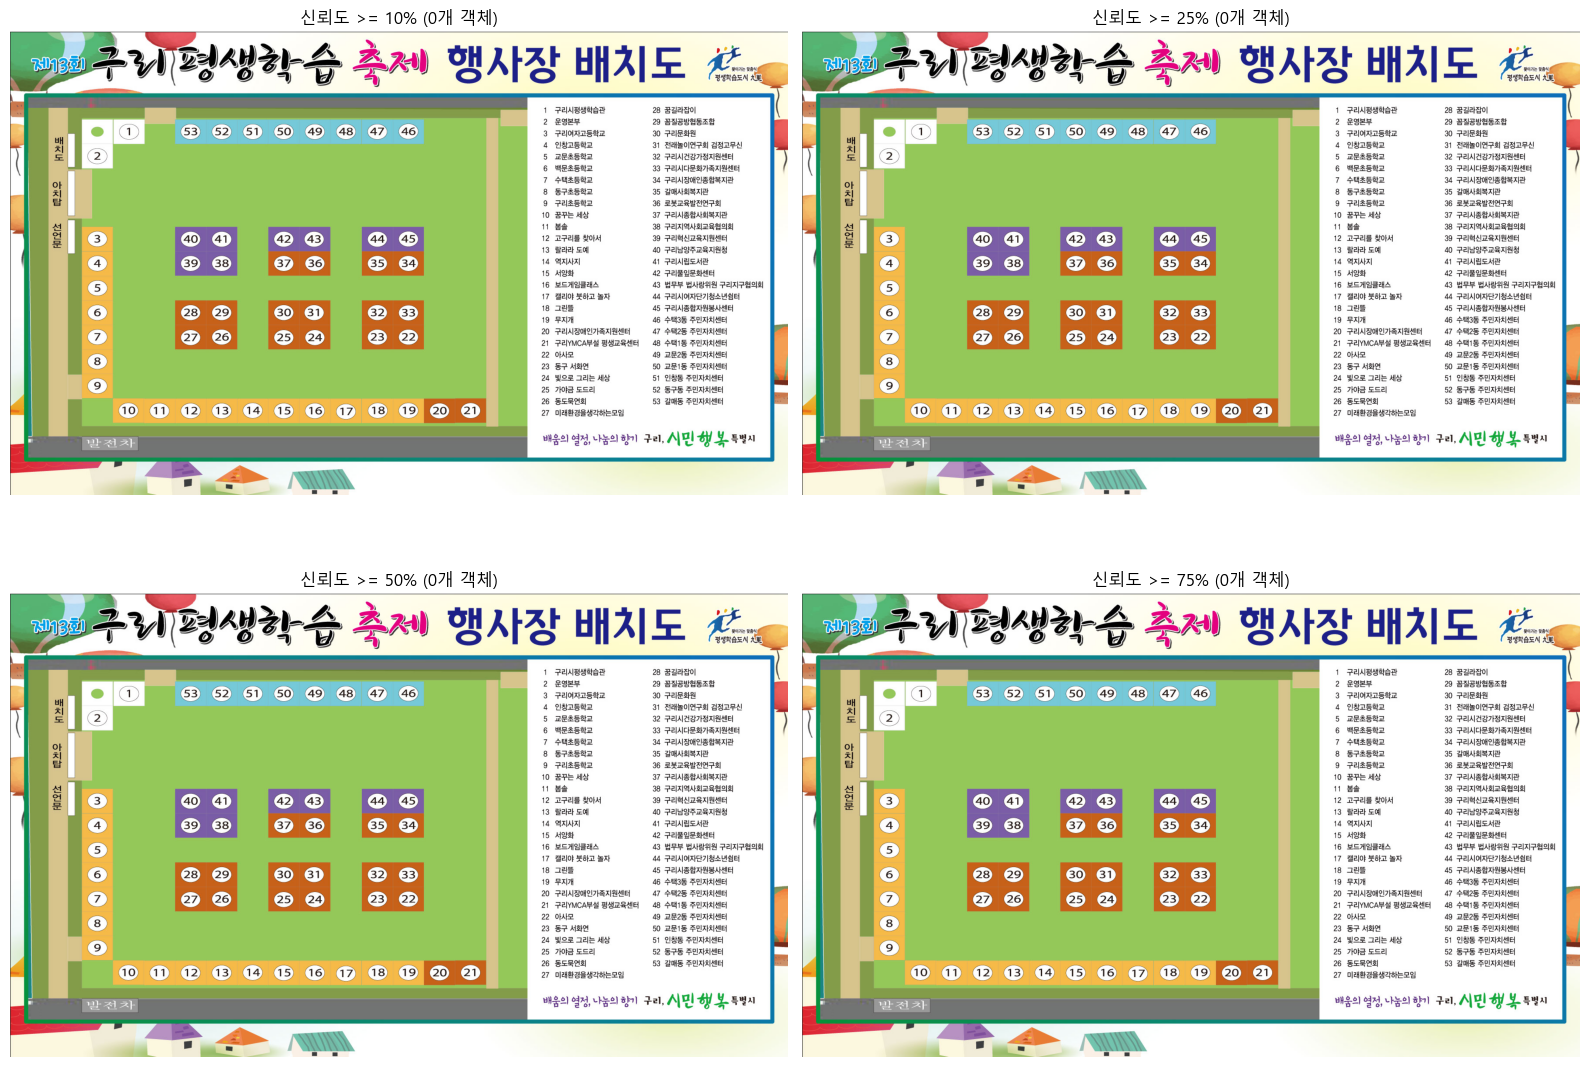

In [37]:
# 신뢰도 임계값 비교 함수
def compare_confidence_thresholds(model, image_path: str, thresholds=[0.1, 0.25, 0.5, 0.75]):
    """다양한 신뢰도 임계값으로 결과 비교"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, conf in enumerate(thresholds):
        results = model.predict(
            source=image_path,
            conf=conf,
            imgsz=640,
            device=device,
            verbose=False
        )
        
        img = results[0].plot()
        
        axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[idx].axis('off')
        axes[idx].set_title(f'신뢰도 >= {conf:.0%} ({len(results[0].boxes)}개 객체)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# 신뢰도 비교 실행
if test_images:
    compare_confidence_thresholds(model, str(test_images[0]))

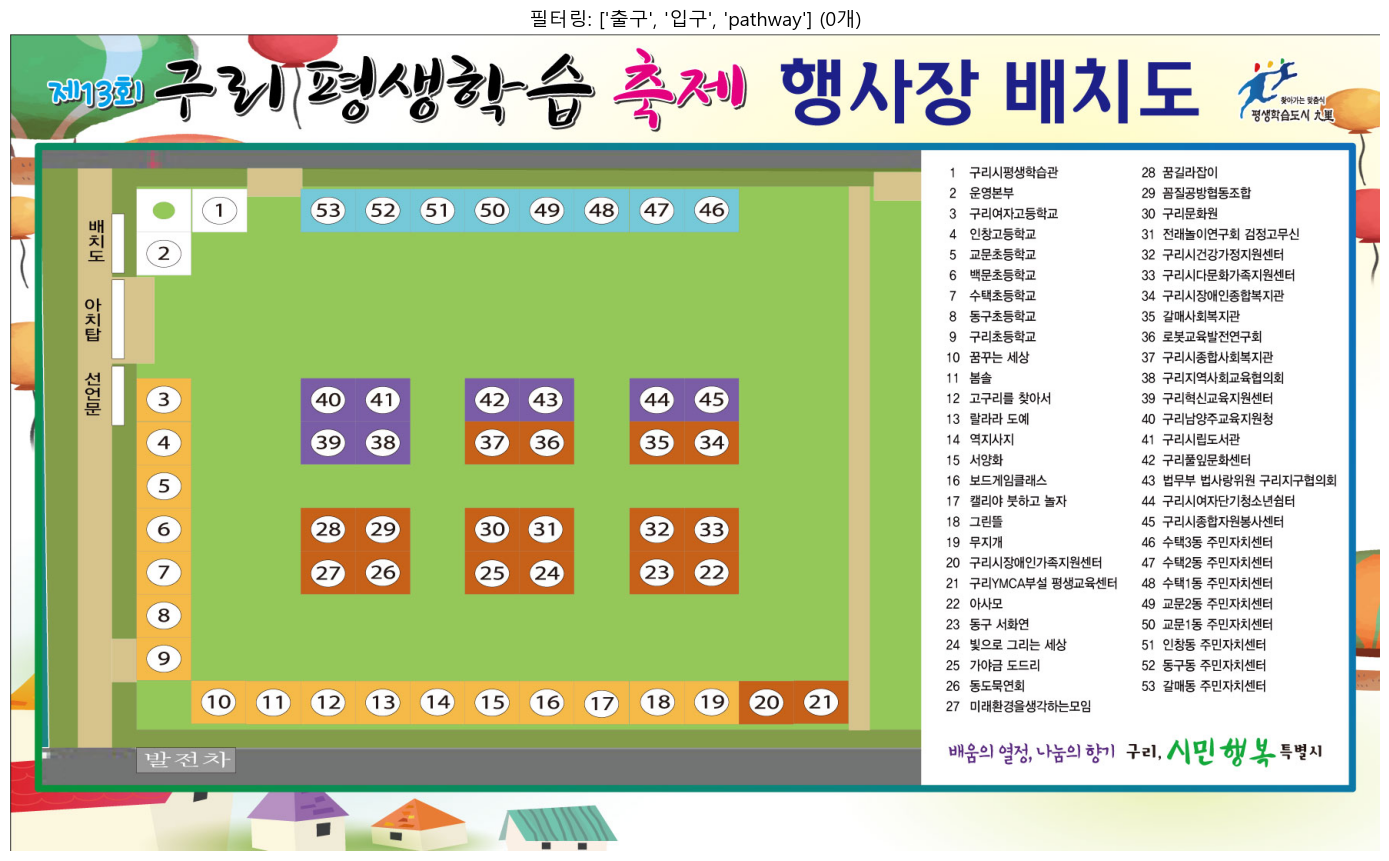

In [39]:
# 특정 클래스 필터링 시각화
def visualize_by_class(model, image_path: str, target_classes: list):
    """특정 클래스만 필터링하여 시각화"""
    target_ids = [idx for idx, name in model.names.items() if name in target_classes]
    
    if not target_ids:
        print(f"⚠️ 해당 클래스가 모델에 없습니다: {target_classes}")
        return
    
    results = model.predict(
        source=image_path,
        conf=0.25,
        imgsz=640,
        device=device,
        classes=target_ids,
        verbose=False
    )
    
    img = results[0].plot()
    
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    target_kr = [CLASS_NAMES_KR.get(c, c) for c in target_classes]
    plt.title(f'필터링: {target_kr} ({len(results[0].boxes)}개)', fontsize=14)
    plt.tight_layout()
    plt.show()

# 안전 관련 클래스만 시각화 (예: 출구, 입구, 통로)
if test_images:
    visualize_by_class(model, str(test_images[0]), ['exit', 'entrance', 'pathway'])

## 12. 행사 안전 분석

인식된 객체를 기반으로 행사 안전 분석을 수행합니다.

### 안전 기준 (festival_safety_AI_solution_guide.md 참조)
- **주 피난통로**: 최소 3m 폭
- **보조 피난통로**: 최소 1.5m 폭
- **최대 대피 거리**: 100m
- **출구 폭**: 100명당 0.6m
- **밀집도 위험 기준**: 3.0명/㎡ 이상

In [40]:
# 안전 분석 함수 (통로는 자동 계산되므로 제외)
def analyze_safety(detected_objects: list, expected_visitors: int = 1000):
    """
    인식된 객체를 기반으로 행사 안전 분석
    
    Args:
        detected_objects: 인식된 객체 리스트
        expected_visitors: 예상 방문자 수
    
    Returns:
        안전 분석 결과
    
    Note:
        통로는 boundary 내부에서 자동 계산되므로 별도 클래스로 인식하지 않습니다.
    """
    analysis = {
        'summary': {},
        'warnings': [],
        'recommendations': [],
        'score': 100,
    }
    
    # 클래스별 집계
    class_counts = {name: 0 for name in CLASS_NAMES}
    for obj in detected_objects:
        class_name = obj.get('class', '')
        if class_name in class_counts:
            class_counts[class_name] += 1
    
    analysis['summary'] = class_counts
    
    # 출구 검사
    if class_counts['exit'] == 0:
        analysis['warnings'].append({
            'level': 'CRITICAL',
            'message': '출구가 감지되지 않았습니다. 비상구 확보가 필요합니다.'
        })
        analysis['score'] -= 30
    elif class_counts['exit'] < 2:
        analysis['warnings'].append({
            'level': 'HIGH',
            'message': f"출구가 {class_counts['exit']}개로 부족합니다. 최소 2개 이상 권장."
        })
        analysis['score'] -= 15
    
    # 입구 검사
    if class_counts['entrance'] == 0:
        analysis['warnings'].append({
            'level': 'MEDIUM',
            'message': '입구가 감지되지 않았습니다.'
        })
        analysis['score'] -= 10
    
    # boundary 검사 (통로 자동 계산을 위해 필요)
    if class_counts['boundary'] == 0:
        analysis['warnings'].append({
            'level': 'MEDIUM',
            'message': 'boundary가 감지되지 않아 통로 영역을 계산할 수 없습니다.'
        })
        analysis['score'] -= 10
    
    # 안전시설 권장
    if class_counts['exit'] > 0:
        required_exit_width = (expected_visitors / 100) * 0.6
        analysis['recommendations'].append(
            f"예상 방문자 {expected_visitors}명 기준, 총 출구 폭 {required_exit_width:.1f}m 이상 필요"
        )
    
    # 점수 보정
    analysis['score'] = max(0, analysis['score'])
    
    # 상태 결정
    if analysis['score'] >= 80:
        analysis['status'] = 'PASS'
        analysis['status_kr'] = '양호'
    elif analysis['score'] >= 50:
        analysis['status'] = 'WARNING'
        analysis['status_kr'] = '주의'
    else:
        analysis['status'] = 'CRITICAL'
        analysis['status_kr'] = '위험'
    
    return analysis

In [41]:
# 안전 리포트 출력 함수
def print_safety_report(analysis: dict):
    """안전 분석 리포트 출력"""
    print("=" * 60)
    print("🛡️ 행사 배치도 안전 분석 리포트")
    print("=" * 60)
    
    # 종합 상태
    status_emoji = {'PASS': '✅', 'WARNING': '⚠️', 'CRITICAL': '🚨'}
    print(f"\n종합 상태: {status_emoji.get(analysis['status'], '❓')} {analysis['status_kr']}")
    print(f"안전 점수: {analysis['score']}/100점")
    
    # 인식된 객체 요약
    print("\n📦 인식된 객체 요약")
    print("-" * 40)
    for name, count in analysis['summary'].items():
        if count > 0:
            print(f"  {CLASS_NAMES_KR.get(name, name):8}: {count}개")
    
    # 경고 사항
    if analysis['warnings']:
        print("\n⚠️ 경고 사항")
        print("-" * 40)
        for w in analysis['warnings']:
            level_emoji = {'CRITICAL': '🚨', 'HIGH': '🔴', 'MEDIUM': '🟡', 'LOW': '🟢'}
            print(f"  {level_emoji.get(w['level'], '•')} [{w['level']}] {w['message']}")
    
    # 권장 사항
    if analysis['recommendations']:
        print("\n💡 권장 사항")
        print("-" * 40)
        for r in analysis['recommendations']:
            print(f"  • {r}")
    
    print("\n" + "=" * 60)

# 안전 분석 실행
if detected:
    safety_analysis = analyze_safety(detected, expected_visitors=1000)
    print_safety_report(safety_analysis)
else:
    print("⚠️ 인식된 객체가 없어 안전 분석을 수행할 수 없습니다.")
    safety_analysis = None

⚠️ 인식된 객체가 없어 안전 분석을 수행할 수 없습니다.


## 13. 결과 내보내기

분석 결과를 JSON, CSV 형식으로 저장합니다.

In [42]:
# JSON 내보내기 함수
def export_to_json(detected_objects: list, safety_analysis: dict, output_path: Path):
    """분석 결과를 JSON 파일로 저장"""
    export_data = {
        'timestamp': datetime.now().isoformat(),
        'detected_objects': detected_objects,
        'safety_analysis': safety_analysis,
    }
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(export_data, f, ensure_ascii=False, indent=2)
    
    print(f"✅ JSON 저장 완료: {output_path}")

# CSV 내보내기 함수
def export_to_csv(detected_objects: list, output_path: Path):
    """인식된 객체를 CSV 파일로 저장"""
    df = pd.DataFrame(detected_objects)
    
    if 'bbox' in df.columns:
        df['x1'] = df['bbox'].apply(lambda x: x[0] if x else None)
        df['y1'] = df['bbox'].apply(lambda x: x[1] if x else None)
        df['x2'] = df['bbox'].apply(lambda x: x[2] if x else None)
        df['y2'] = df['bbox'].apply(lambda x: x[3] if x else None)
        df = df.drop('bbox', axis=1)
    
    df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ CSV 저장 완료: {output_path}")

# 결과 내보내기 실행
if detected and safety_analysis:
    export_to_json(detected, safety_analysis, RESULTS_DIR / 'analysis_result.json')
    export_to_csv(detected, RESULTS_DIR / 'detected_objects.csv')

## 14. 모델 내보내기

학습된 모델을 다른 형식(ONNX)으로 내보내 배포에 활용할 수 있습니다.

In [43]:
# ONNX 모델 내보내기 함수
def export_to_onnx(model_path: Path):
    """학습된 모델을 ONNX 형식으로 내보내기"""
    if not model_path.exists():
        print(f"⚠️ 모델 파일이 없습니다: {model_path}")
        return None
    
    model = YOLO(str(model_path))
    
    print("📦 ONNX 모델 내보내기 중...")
    onnx_path = model.export(
        format='onnx',
        imgsz=640,
        simplify=True,
        dynamic=False
    )
    
    print(f"✅ ONNX 모델 저장 완료: {onnx_path}")
    return onnx_path

# ONNX 내보내기 실행 (학습된 모델이 있을 때)
if best_model_path.exists():
    export_to_onnx(best_model_path)

📦 ONNX 모델 내보내기 중...
Ultralytics 8.3.234  Python-3.10.11 torch-2.9.1+cpu CPU (Intel Core i5-10210U 1.60GHz)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'C:\Users\user\Documents\lab\results\event_layout_train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 12, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   --- ------------------------------------ 1.6/16.5 MB 13.9 MB/s eta 0:00:02
   ------------- -------------------------- 5.5/16.5 MB 16.0 MB/s eta 0:00:01
   ------------------------- -------------- 10.5/16.5 MB 19.3 MB/s eta 0:00:01
   ------------------------------------ --- 14.9/16.

## 15. 정리 및 다음 단계

### 학습 내용 요약
1. ✅ YOLOv8 환경 설정 및 패키지 설치
2. ✅ 프로젝트 디렉토리 구조 생성
3. ✅ 행사 배치도 전용 8개 클래스 정의
4. ✅ 데이터 준비 및 라벨링 (LabelImg)
5. ✅ YOLOv8 커스텀 모델 학습
6. ✅ 모델 검증 및 성능 평가
7. ✅ 새로운 이미지 추론
8. ✅ 결과 시각화
9. ✅ 행사 안전 분석
10. ✅ 결과 내보내기 (JSON, CSV, ONNX)

### 다음 단계
- [ ] 더 많은 배치도 이미지 수집 (목표: 100장+)
- [ ] 라벨링 완료 및 모델 재학습
- [ ] 하이퍼파라미터 튜닝으로 성능 개선
- [ ] Streamlit 웹 앱 개발
- [ ] FastAPI 서버 구축
- [ ] 실시간 분석 시스템 구현

### 참고 자료
- [YOLOv8 공식 문서](https://docs.ultralytics.com)
- [LabelImg GitHub](https://github.com/tzutalin/labelImg)
- [행사 안전 관리 가이드](festival_safety_AI_solution_guide.md)

---
**노트북 작성일**: 2025-11-25  
**버전**: 1.0.0